Kerrian LE CAILLEC - Thomas MIGLIASSO

## TP Question III

On travaille dans le cadre du modèle de Black & Scholes. Dans toutes ces questions, on
considère un call européen de maturité $T$ et de strike $K$. On pourra prendre comme valeurs de référence $S_0 = 100, K = 100, T = 1, r = 0.05, \sigma = 0.20, d=12, B=140, L=95$.


1. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière up-and-out de niveau $B$ en fonction de $S_0$ (comparer avec le call standard). Ajouter le prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter

In [2]:
import numpy as np
from scipy.stats import norm, skew, kurtosis
import matplotlib.pyplot as plt

In [11]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
d = 12
B = 140
L = 95
N = 10**4

In [4]:
def call_price_black_scholes(K, T, S0, r, sigma):
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [5]:
def monte_carlo_discrete_path(N, n, T, S0, r, sigma):
    random_factors = np.exp((r - sigma**2/2)*T/n + sigma * np.random.normal(scale=np.sqrt(T / n), size=(N, n)))
    return S0 * np.cumprod(np.insert(random_factors, 0, 1, axis=1), axis=1)

def monte_carlo_continuous(N, T, S0, r, sigma):
    X = np.random.normal(scale=np.sqrt(T), size=(N,)) + (r/sigma - sigma/2)*T
    random_factors = np.exp(sigma * X)
    maxima = 0.5 * (X + np.sqrt(X**2 - 2*T*np.log(np.random.uniform(size=(N,)))))
    return S0 * random_factors, maxima

In [6]:
def standard_error(Xs):
    return np.sqrt(np.var(Xs, ddof=1) / len(Xs))

def discrete_payoff(N, n, K, T, S0, r, sigma, B, alpha=0.01):
    mc_price = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price[:, -1] - K) * np.all(mc_price < B, axis=1).astype(int)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)

def continuous_payoff(N, K, T, S0, r, sigma, B, alpha=0.01):
    mc_price, maxima = monte_carlo_continuous(N, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price - K) * (maxima < np.log(B/S0)/sigma).astype(int)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    interval = Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)
    del payoffs
    return Cn, interval

In [13]:
def plot_montecarlo_prices(ax, S_range, payoff_function, legend, **kwargs):
    Cns, Cns_up, Cns_down = [], [], []
    for s in S_range:
        Cn, error_Cn = payoff_function(S0=s, **kwargs)
        Cns.append(Cn)
        Cns_up.append(error_Cn[1])
        Cns_down.append(error_Cn[0])

    ax.plot(S_range, Cns, label=legend)
    ax.plot(
        S_range, Cns_up, linestyle=":", color="red", label=f"{legend} $\pm$ error"
    )
    ax.plot(S_range, Cns_down, linestyle=":", color="red")
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("Monte-Carlo price")
    ax.set_title("Evolution of the Monte-Carlo price in function of N")
    ax.legend()

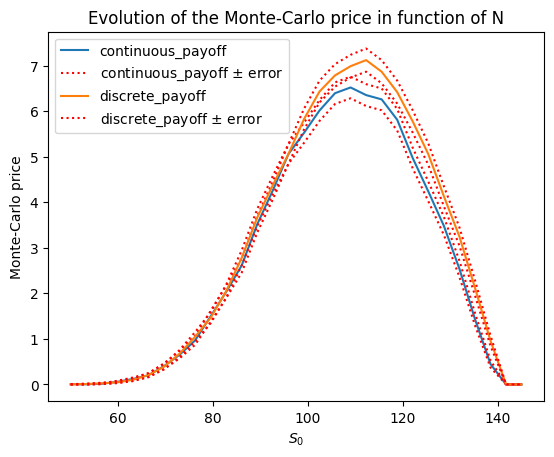

In [14]:
S_range = np.linspace(50, 145, 30)

_, ax = plt.subplots()
plot_montecarlo_prices(
    ax,
    S_range,
    continuous_payoff,
    "continuous_payoff",
    N=N,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=B,
)

plot_montecarlo_prices(
    ax,
    S_range,
    discrete_payoff,
    "discrete_payoff",
    N=N,
    n=100,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=B,
)
plt.show()


2. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière
up-and-out (variante discr`ete) en fonction du nombre de dates d’observations. Ajouter le
prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter.


In [ ]:
def plot_montecarlo_n(ax, n_range, payoff_function, legend, **kwargs):
    Cns, Cns_up, Cns_down = [], [], []
    for n in n_range:
        Cn, error_Cn = payoff_function(n=int(n), **kwargs)
        Cns.append(Cn)
        Cns_up.append(error_Cn[1])
        Cns_down.append(error_Cn[0])

    ax.plot(n_range, Cns, label=legend)
    ax.plot(
        n_range, Cns_up, linestyle=":", color="red", label=f"{legend} $\pm$ error"
    )
    ax.plot(n_range, Cns_down, linestyle=":", color="red")
    ax.set_xlabel("Number of time subdivisions")
    ax.set_ylabel("Monte-Carlo price")
    ax.set_title("Evolution of the Monte-Carlo price in function of N")
    ax.legend()

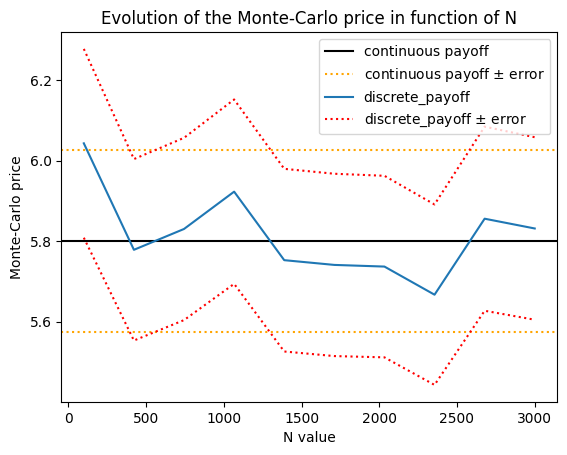

In [12]:
n_range = np.linspace(100, 3000, 10)

_, ax = plt.subplots()
Cn, errors = continuous_payoff(N, K, T, S0, r, sigma, B, alpha=0.01)
ax.axhline(Cn, color="black", label="continuous payoff")
ax.axhline(errors[0], linestyle=":", color="orange")
ax.axhline(errors[1], linestyle=":", color="orange", label=f"continuous payoff $\pm$ error")


plot_montecarlo_n(
    ax,
    n_range,
    discrete_payoff,
    "discrete_payoff",
    N=N,
    S0=S0,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=B,
)

plt.show()

3. Reprendre la question 1 pour un call down-and-in de niveau L.

In [16]:
def discrete_down_and_in(N, n, K, T, S0, r, sigma, B, alpha=0.01):
    mc_price = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price[:, -1] - K) * np.all(mc_price > B, axis=1).astype(int)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)

def continuous_down_and_in(N, K, T, S0, r, sigma, B, alpha=0.01):
    mc_price, maxima = monte_carlo_continuous(N, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price - K) * (maxima > np.log(B/S0)/sigma).astype(int)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    interval = Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)
    del payoffs
    return Cn, interval

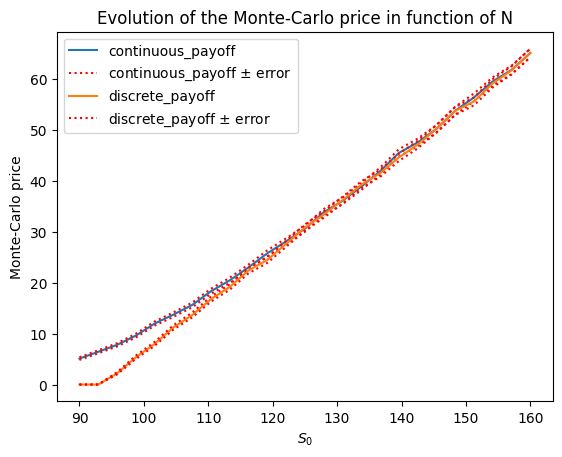

In [ ]:
S_range = np.linspace(70, 160, 25)

_, ax = plt.subplots()
plot_montecarlo_prices(
    ax,
    S_range,
    continuous_down_and_in,
    "continuous_payoff",
    N=N,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=L,
)

plot_montecarlo_prices(
    ax,
    S_range,
    discrete_down_and_in,
    "discrete_payoff",
    N=N,
    n=100,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=L,
)
plt.show()